# Tutorial 5a: Model selection I

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t5a_model_selection_1.ipynb).*

In [6]:
import itertools
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numerical differentiation packages
import numdifftools as ndt

# Import pyplot for plotting
import matplotlib.pyplot as plt
import matplotlib.patches
import beeswarm

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Can we use Dorsal-Venus as a proxy for wild type Dorsal?

If you recall from [Homework 3.2](http://bebi103.caltech.edu/2015/homework/hw3.html#Problem-3.2:-Dorsal-gradients-in-Drosophila-embryos-(50-pts)), we investigated how using a Venus fusion to Dorsal affects the width of the gradient.  We plotted a box plot comparing different genotypes/observation methods.  In the [research paper](http://bebi103.caltech.edu/2015/protected/papers/reeves_2012.pdf), the authors checked to see is the wild type anti-Dorsal stain have different gradient widths than the Dorsal-Venus fusion.  They used NHST (null hypothesis significance testing) to see if the two were different.  We will discuss NHST and other frequentist methods next week.  For now, we will address the problem of the differences of these two samples using Bayesian hypothesis testing.

Before we proceed, though, I pause to say that this exercise is not useful in my opinion.  As I have said earlier, *of course we know the two are different*, the real question is: how different are they?  I think computing a posterior distribution $P(\delta \mid D, I)$, where $\delta = \mu_\mathrm{Venus} - \mu_\mathrm{wt}$ is far more instructive.

We begin by revisiting the data and making a beeswarm plot of the data.

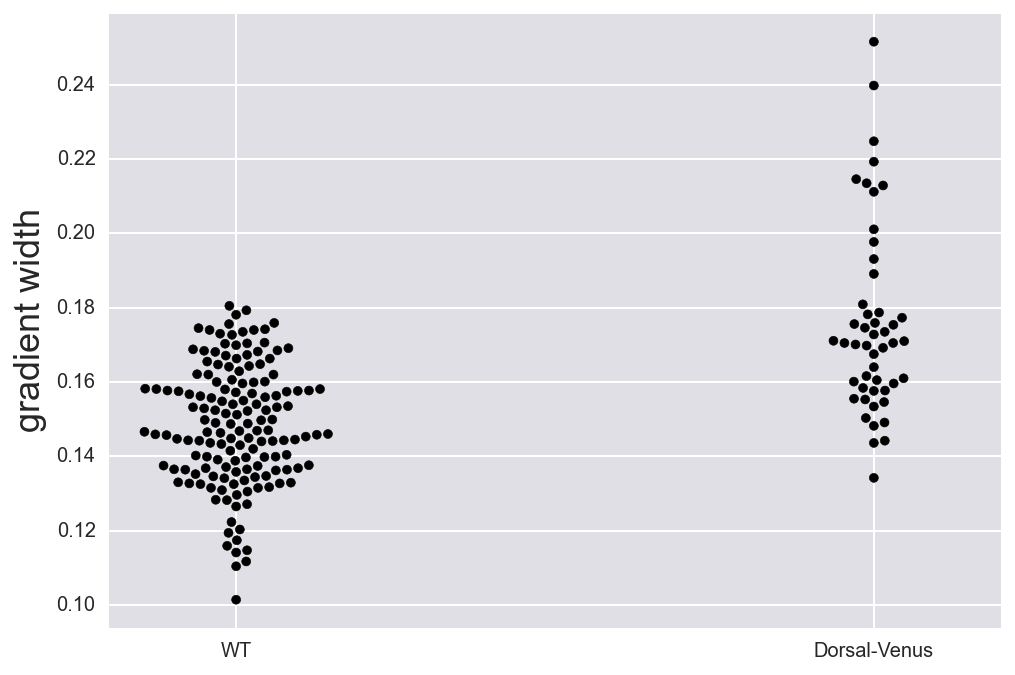

In [8]:
# Load data into DataFrame
file_name = '../data/reeves_et_al/reeves_gradient_width_various_methods.csv'
df = pd.read_csv(file_name, comment='#', header=[0, 1])

# For x-labels, we only care about imaging method, so reset columns
df.columns = df.columns.get_level_values(1)

# Tidy it
df = pd.melt(df, var_name='genotype', value_name='gradient width')
df = df.dropna()

# Make a beeswarm plot
bs_plot, ax = beeswarm.beeswarm(
        [df[df.genotype=='cross-sections']['gradient width'].values, 
         df[df.genotype=='anti-Dorsal']['gradient width'].values], 
        labels=['WT', 'Dorsal-Venus'])
plt.ylabel('gradient width')

Some of the Dorsal-Venus samples are higher, but it is possible that they come from the same distribution.  So, we will compare two models.  
* **Model A**: The WT and Dorsal-Venus gradient widths are drawn from the same Gaussian distribution.
* **Model B**: The WT and Dorsal-Venus gradient widths are drawn from different Gaussian distributions.

I would argue that $P(M_2\mid I) \gg P(M_1 \mid I)$, and our model selection is over and we should proceed to compute the posterior distribution for the difference in the mean gradient width between to two types of samples.  However, for the purposes of demonstrating this type of model selection, I will take $P(M_2\mid I) \approx P(M_1 \mid I)$.

### Bayesian model selection

Section 9.4 of [Gregory's book](http://www.cambridge.org/us/academic/subjects/statistics-probability/statistics-physical-sciences-and-engineering/bayesian-logical-data-analysis-physical-sciences-comparative-approach-mathematica-support) gives a detailed account of how to do a Bayesian comparison of two independent samples.  I encourage you to read that.  We will instead take the approach of Sivia, as he lays out in section 4.3, which includes some simplifications, such as approximating distributions as Gaussians.

We set up the problem similarly as in our frequentist interlude.  We have two data sets (e.g., wild type and Venus), which we will call $1$ and $2$.  We have two models, $A$ and $B$.  Model $A$ states that both data sets come from the same 

We consider two models.  Model A states that the data in set 1 and set 2 were drawn from effectively the same process; that is to say, they are both drawn from Gaussian distributions with the same mean $\mu$ and standard deviation $\sigma$.  Model B states that the data in set 1 are different from set 2 in that they have different means, $\mu_1$ and $\mu_2$, but they have the same standard deviation $\sigma$.  As we learned in lecture, the **odds ratio** between model A and model B is

\begin{align}
O_{AB} = \frac{P(A~|~D,I)}{P(B~|~D,I)}.
\end{align}

Here, $D = D_1 + D_2$, the combined set of data.

By Bayes Theorem,

\begin{align}
P(A~|~D,I) = \frac{P(D~|~A,I)\,P(A~|~I)}{P(D~|~I)},
\end{align}

so

\begin{align}
O_{AB} = \frac{P(D~|~A,I)}{P(D~|~B,I)}\,\frac{P(A~|~I)}{P(B~|~I)}.
\end{align}


The final ratio is the ratio of our prior beliefs about the respective models.  We have no reason *a priori* to assume one is more probable than the other, so we set this ratio to unity.  We then have to compute $P(D~|~A,I)$ and $P(D~|~B,I)$.  We recognize these as the evidence in our familiar form of Bayes Theorem.

\begin{align}
P(\mu,\sigma~|~D,A,I) &= \frac{P(D~|~\mu,\sigma,A,I)\,P(\mu,\sigma~|~A,I)}{P(D~|~A,I)} \\[1mm]
P(\mu_1,\mu_2,\sigma~|~D,B,I) &= \frac{P(D~|~\mu_1,\mu_2,\sigma,B,I)\,P(\mu_1, \mu_2,\sigma~|~B,I)}{P(D~|~B,I)}.
\end{align}

Because the posterior has to be normalized, we have

\begin{align}
P(D~|~A,I) &= \int\mathrm{d}\sigma \int \mathrm{d}\mu \,P(D~|~\mu,\sigma,A,I)\,P(\mu,\sigma~|~A,I) \\[1mm]
P(D~|~B,I) &= \int\mathrm{d}\sigma \int \mathrm{d}\mu_1 \int\mathrm{d}\mu_2 \,P(D~|~\mu_1,\mu_2,\sigma,B,I)\,P(\mu_1, \mu_2,\sigma~|~B,I).
\end{align}

So, we just have to assign the priors and likelihoods, evaluate some integrals, and we have our odds ratio!

As we discussed in lecture, if the integrand in the above equations is sharply peaked (meaning the posterior is peaked), we can use Laplace's approximation to compute the integral.  In particular,

\begin{align}
P(D~|~A,I) &\approx P(D~|~\mu^*,\sigma^*,A,I)\,P(\mu^*,\sigma^*~|~A,I)\,\sqrt{2\pi \sigma_\mu^2\,\sigma_\sigma^2},
\end{align}

where $\sigma_\mu$ is the error in our estimate of $\mu$, $\sigma_\sigma$ is the error in the estimate of $\sigma$, and the asterisks indicate values for which the posterior is maximal.  (Here, we have made the approximation that $\mu$ and $\sigma$ are independent of each other.)  When we were doing parameter estimation, we found

\begin{align}
\mu^* &= \bar{x} = \frac{1}{n}\sum_{i\in D} x_i, \\[1mm]
(\sigma^*)^2 &= \frac{1}{n}\sum_{i\in D} (x_i - \bar{x})^2 \\[1mm]
\sigma_\mu^2 &= \frac{1}{n(n-1)}\sum_{i\in D} (x_i - \bar{x})^2.
\end{align}


We will assume a uniform prior for $\mu$,

\begin{align}
P(\mu~|~A,I) = \frac{1}{\mu_\mathrm{max} - \mu_\mathrm{min}},
\end{align}

so

\begin{align}
P(\mu^*,\sigma^*~|~A,I) = \frac{1}{\sigma^*(\mu_\mathrm{max} - \mu_\mathrm{min})}
\end{align}

Finally,

\begin{align}
P(D~|~\mu^*,\sigma^*,A,I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi (\sigma^*)^2}}\,
\exp\left\{-\frac{(x_i - \mu^*)^2}{2(\sigma^*)^2}\right\}.
\end{align}

So, now we have all the pieces for $P(A~|~D,I)$.

We do a similar analysis for $P(B~|~D,I)$.

\begin{align}
P(D~|~B,I) &\approx P(D~|~\mu_1^*,\mu_2^*, \sigma^*,B,I)\,P(\mu_1^*,\mu_2^*,\sigma^*~|~B,I)\,\sqrt{2\pi \sigma_{\mu_1}^2\,\sigma_{\mu_2}^2\,\sigma_\sigma^2}
\end{align}


Because the samples are assumed to be independent of each other,

\begin{align}
P(D~|~\mu_1,\mu_2,\sigma,B,I) = P(D_1~|~\mu_1,\sigma,B,I)\,P(D_2~|~\mu_2,\sigma,B,I),
\end{align}

so we have

\begin{align}
P(D~|~\mu_1^*,\mu_2^*, \sigma^*,B,I) &= \prod_{i\in D_1} \frac{1}{\sqrt{2\pi (\sigma^*)^2}}\,
\exp\left\{-\frac{(x_i - \mu_1^*)^2}{2(\sigma^*)^2}\right\} \\[1mm]
&\times \prod_{i\in D_2} \frac{1}{\sqrt{2\pi (\sigma^*)^2}}\,
\exp\left\{-\frac{(x_i - \mu_2^*)^2}{2(\sigma^*)^2}\right\}.
\end{align}

Analogously to model A, we have

\begin{align}
\mu_1^* &= \bar{x}_1 = \frac{1}{n_1}\sum_{i\in D_1} x_i, \\[1mm]
\mu_2^* &= \bar{x}_2 = \frac{1}{n_2}\sum_{i\in D_2} x_i, \\[1mm]
\sigma_{\mu_1}^2 &= \frac{1}{n_1(n_1-1)}\sum_{i\in D_1} (x_i - \bar{x}_1)^2,\\[1mm]
\sigma_{\mu_2}^2 &= \frac{1}{n_2(n_2-1)}\sum_{i\in D_2} (x_i - \bar{x}_2)^2.
\end{align}

Finally, we assume $\mu_1$ and $\mu_2$ have the same prior as $\mu$, giving

\begin{align}
P(\mu_1^*,\mu_2^*,\sigma^*~|~B,I) = \frac{1}{\sigma^*(\mu_\mathrm{max} - \mu_\mathrm{min})^2}.
\end{align}

We now have all the pieces of $P(B~|~D,I)$!

Putting it all together and canceling terms,

\begin{align}
O_{AB} &= (\mu_\mathrm{max} - \mu_\mathrm{min})\,\frac{\sigma_\mu}{\sigma_{\mu_1}\sigma_{\mu_2}}\\[1mm]
&\times \exp\left\{-\frac{1}{2(\sigma^*)^2}\left(\sum_{i\in D}(x_i - \mu^*)^2 - \sum_{i\in D_1}(x_i - \mu_1^*)^2 - \sum_{i\in D_2}(x_i - \mu_2^*)^2\right)\right\}.
\end{align}

In the case of the Reeves, Trisnadi, et al. data, we will assume $\mu_\mathrm{min} = 0$ (an infinitely sharp morphogen gradient) and $\mu_\mathrm{max} = 7.5$ (the gradient is barely detectable; the morphogen profile only varies abour 1%).  Let's go ahead and calculate the odds ratio.  We will do it over and over again, so let's write a function.

In [7]:
def log_odds_ratio(x_1, x_2, mu_range):
    """
    Computes the odds ratio for two data sets, x_1 and x_2.  
    Model A: data sets have same mean
    Model B: data sets have different means
    
    Returns ln(prob(A) / prob(B)).
    
    Assumes the data sets are both Gaussian distributed and  have the same 
    variance.  Uses Laplace's approximation to compute the evidence.
    """
    # Get length of data sets for convenience
    n_1 = float(len(x_1))
    n_2 = float(len(x_2))
    n = n_1 + n_2
    
    # Construct master data set
    x = np.concatenate((x_1, x_2))
   
    # Compute means of sets
    x_bar = x.mean()
    x_1_bar = x_1.mean()
    x_2_bar = x_2.mean()
    
    # Compute most probable sigma (same for both data sets)
    sigma_sq = ((x - x_bar)**2).sum() / n
    
    # Compute sigma_mu's
    sigma_mu_sq = sigma_sq / (n - 1.0)
    sigma_mu_1_sq = ((x_1 - x_1_bar)**2).sum() / n_1 / (n_1 - 1.0)
    sigma_mu_2_sq = ((x_2 - x_2_bar)**2).sum() / n_2 / (n_2 - 1.0)

    # Compute parts in exponential
    sum_exp = ((x - x_bar)**2).sum() - ((x_1 - x_1_bar)**2).sum() \
                    - ((x_2 - x_2_bar)**2).sum()
    
    # Add everything up to return
    return np.log(mu_range) \
           + 0.5 * (np.log(sigma_mu_sq) - np.log(sigma_mu_1_sq) 
                     - np.log(sigma_mu_1_sq)) \
           - sum_exp / 2.0 / sigma_sq

An now, let's compute the odds ratio for each of our pairs.

In [8]:
mu_range = 7.5
o_wt_dorsal = np.exp(log_odds_ratio(df.wt.dropna(), df.dorsal.dropna(), 
                                    mu_range))
o_wt_venus = np.exp(log_odds_ratio(df.wt.dropna(), df.venus.dropna(), 
                                   mu_range))
o_wt_gfp = np.exp(log_odds_ratio(df.wt.dropna(), df.gfp.dropna(), 
                                 mu_range))
o_dorsal_gfp = np.exp(log_odds_ratio(df.dorsal.dropna(), df.gfp.dropna(), 
                                       mu_range))
o_venus_gfp = np.exp(log_odds_ratio(df.venus.dropna(), df.gfp.dropna(), 
                                       mu_range))

# Print results
print("""
Constructs               p-values            Odds ratios
==========               ========            =========== 
WT/Dorsal                {0:.2e}             {5:.2e}
WT/Venus                 {1:.2e}             {6:.2e}
WT/GFP                   {2:.2e}             {7:.2e}
Dorsal/GFP               {3:.2e}             {8:.2e}
Venus/GFP                {4:.2e}             {9:.2e}
""".format(p_wt_dorsal, p_wt_venus, p_wt_gfp, p_dorsal_gfp, p_venus_gfp, 
           o_wt_dorsal, o_wt_venus, o_wt_gfp, o_dorsal_gfp, o_venus_gfp))


Constructs               p-values            Odds ratios
==========               ========            =========== 
WT/Dorsal                1.65e-04             5.17e+00
WT/Venus                 1.84e-13             2.97e-07
WT/GFP                   1.48e-43             5.32e-22
Dorsal/GFP               8.05e-17             5.63e-05
Venus/GFP                3.46e-14             3.64e-04



The odds ratios favor the null hypothesis (model A) more than we might expect from looking at the p-values, particularly the WT/Dorsal pair.  Note, though, that the range of values of $\mu$ from the prior have a strong effect on the odds ratio.  Nonetheless, even for small values of $\mu$ (like $\mu = 1$), there is still a substantial probability that model A (the same mean) is true.  This is because the penalty of having an extra parameter due to the Occam factor tends to favor simpler models with fewer parameters.

### Of course the means are different. How different are they?

In the above analysis, we assumed $P(A~|~I) = P(B~|~I)$.  I cavalierly said that we had no *a priori* reason to favor one over the other.  But is this so?  *Of course not!*  We would *expect* the means to be different!  We are looking at different molecules after all.  We also expect $\sigma$ to be different.

So, perhaps the better question is: how different are they?  Specifically, we would like to know

\begin{align}
P(\delta, \sigma_1, \sigma_2~|~D_1, D_2, I),
\end{align}

where $\delta = \mu_1 - \mu_2$.  This is essentially the [Behrens-Fisher problem](http://en.wikipedia.org/wiki/Behrens–Fisher_problem), and there are analytical expressions for it (e.g., in section 9.4.4 of Gregory's book).

But let's not bother with that.  Let's just use MCMC!  We will sample

\begin{align}
P(\mu_1, \mu_2, \sigma_1, \sigma_2~|~D_1, D_2, I) &\propto P(\mu_1, \sigma_1~|~D_1, I)\,P(\mu_2, \sigma_2~|~D_2, I)\\[1mm]
&\times P(\mu_1~|~I)\,P(\mu_2~|~I)\,P(\sigma_1~|~I)\,P(\sigma_2~|~I),
\end{align}

and from this we can compute $P(\delta, \sigma_1, \sigma_2~|~D_1, D_2, I)$.  We will use a uniform prior on $\mu_1$ and $\mu_2$ and Jeffreys priors on $\sigma_1$ and $\sigma_2$.

First, we define the log posterior.

In [8]:
# Define log of the posterior
def log_posterior(p, x_1, x_2, mu_min, mu_max):
    """
    Returns the log of the posterior consisting of the product of Gaussians.
    p[0] = mu_1
    p[1] = mu_2
    p[2] = sigma_1
    p[3] = sigma_2
    """
    # Unpack parameters
    mu_1, mu_2, sigma_1, sigma_2 = p
    
    # Make sure we have everything in the right range
    if (mu_min < mu_1 < mu_max) and (mu_min < mu_2 < mu_max) \
              and (sigma_1 > 0.0) and (sigma_2 > 0.0): 
        n_1 = len(x_1)
        n_2 = len(x_2)
        
        # Compute separate parts of posterior from each sample
        log_post_1 = -(n_1 + 1) * np.log(sigma_1) \
           - ((x_1 - mu_1)**2).sum() / 2.0 / sigma_1**2
        log_post_2 = -(n_2 + 1) * np.log(sigma_2) \
           - ((x_2 - mu_2)**2).sum() / 2.0 / sigma_2**2

        # Add them up to return
        return log_post_1 + log_post_2
    else:
        # Return minus infinity where posterior is zero
        return -np.inf

Now set up the MCMC parameters.

In [9]:
n_dim = 4        # number of parameters in the model
n_walkers = 50   # number of MCMC walkers
n_burn = 500    # "burn-in" period to let chains stabilize
n_steps = 5000 # number of MCMC steps to take after burn-in

We need to define the range of our prior.

In [10]:
# Define the range of mu
mu_min = 0.0
mu_max = 7.5

Proceeding as before: set up starting points of walkers.

In [11]:
# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(mu_min, mu_max, n_walkers)     # mu_1
p0[:,1] = np.random.uniform(mu_min, mu_max, n_walkers)     # mu_2
p0[:,2] = np.random.exponential(1.0, n_walkers)            # sigma_1
p0[:,3] = np.random.exponential(1.0, n_walkers)            # sigma_2

Now we'll instantiate the sampler, do the burn in, and then do our sampling!  For this run, we'll compare wild type and Venus.  Remember, $\mu_1$ in this case is the mean gradient width for wild type, $\mu_2$ is the mean gradient width for Venus, $\sigma_1$ is the standard deviation describing spread in the wild type gradient width measurements, and $\sigma_1$ is the standard deviation describing spread in the Venus gradient width measurements.

In [12]:
# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                            args=(df.wt, df.venus, mu_min, mu_max))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

To see the probability distribution of difference of means between wild type and Venus, we simple do a histogram of the samples we took during the MCMC calculation.

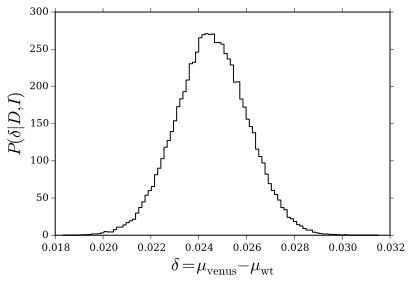

In [64]:
# Plot the histogram of mean differences
n, b, p = plt.hist(sampler.flatchain[:,1] - sampler.flatchain[:,0], 
                   bins=100, normed=True, histtype='step', color='k')

# Label axes
plt.xlabel(r'$\delta = \mu_\mathrm{venus} - \mu_\mathrm{wt}$')
plt.ylabel(r'$P(\delta|D,I)$');

The difference in the mean between wild type and Venus is about 0.025, or approximately 15% of the wild type gradient width.

This is far more informative to the scientist than whether or not we can reject a null hypothesis that the means are the same.

## Model selection for the Good, et al. data

Recall from last time that we were considering two different theoretical models for the spindle length vs. droplet size data presented in Good, et al.

#### Model A

In Model A, the spindle size is independent of droplet size.  The corresponding equation is

\begin{align}
l = \theta.
\end{align}

We assume the data are Gaussian distributed about this $\theta$, which an unknown variance $\sigma$.

#### Model B

We define by Model B the full relation between spindle length and droplet diameter,

\begin{align}
l(d;\gamma,\theta) \approx \frac{\gamma d}{\left(1+(\gamma d/\theta)^3\right)^{\frac{1}{3}}}.
\end{align}

As in Model A, we assume the data are Gaussian distributed about this $\theta$, which an unknown variance $\sigma$.

### The odds ratio
As given in lecture, the odds ratio is

\begin{align}
O_{AB} \approx \left(\frac{P(A\mid I)}{P(B\mid I)}\right)
\left(\frac{P(D\mid \theta^*, \sigma^*, A, I)}{P(D\mid \theta^*, \gamma^*, \sigma^*, B, I)}\right)
\left(\frac{P(\theta^*, \sigma^* \mid A, I) \,2\pi\,\sqrt{\det\boldsymbol{\sigma_A^2}}}
{P(\theta^*, \gamma^*, \sigma^*\mid B, I)\,(2\pi)^{3/2} \sqrt{\det\boldsymbol{\sigma}_B^2}}\right),
\end{align}

where $\boldsymbol{\sigma}_B$ is the covariance matrix computed for Model B.  So, to compute the odds ratio, we need to first specify the prior odds of the two models.  We will assume that

\begin{align}
\frac{P(A\mid I)}{P(B\mid I)} \approx 1,
\end{align}

since we are not sure which model is correct *a priori* (that was the whole purpose of the experiment).  We also need to specify the respective priors.  We will assume that $\theta$, $\gamma$, and $\sigma$ are all independent.  Further, since $\theta$ and $\sigma$ represent the same thing in Model A and in Model B, we assume $P(\theta, \sigma \mid A, I) = P(\theta, \sigma \mid B, I)$.  Finally, we know that $0 \le \gamma \le 1$ by physical considerations.  We will take a uniform prior for $P(\gamma\mid B, I)$, so the ratio

\begin{align}
\frac{P(\theta^*, \sigma^*\mid A, I)}
{P(\theta^*, \gamma^*, \sigma^*\mid B, I)} = 1.
\end{align}

All we have left to do is to compute the MAP and the covariance at the MAP for each model, and then to evaluate the likelihood at the MAP.  So, we will first define the likelihoods for both models.

In <a href="http://bebi103.caltech.edu/2015/tutorials/t3a_regression.html#Parameter-estimation-for-Model-b-(nonlinear-regression)">Tutorial 3a</a>, we found the MAP and covariance for both Model A and Model B.  We repeat that here to get the results in hand, first for Model A, which is computed directly from the theoretical results derived in Tutorial 3a.  We store the results as NumPy arrays for ease of comparison between the Model A, which is one-dimensional, and Model B, which is two-dimensional.

In [10]:
# Estimate spindle length and variance for Model A
theta_A = np.array([df['Spindle Length (um)'].mean()])
cov_B = np.array([[df['Spindle Length (um)'].std()**2 
                      / df['Spindle Length (um)'].count()]])

# Define log posterior for Model A

Now, we compute the results for Model B.

In [9]:
# Load data into DataFrame
df = pd.read_csv('../data/good_et_al/invitro_droplet_data.csv', comment='#')

# Define the model
def spindle_length(p, d):
    """
    Theoretical model for spindle length
    """
    theta, gamma = p
    return gamma * d / np.cbrt(1 + (gamma * d / theta)**3)

def resid(p, d, ell):
    """
    Residuals for spindle length model.
    """
    return ell - spindle_length(p, d)

def log_post(p, d, ell):
    """
    Compute log of posterior for single set of parameters.
    p[0] = theta
    p[1] = gamma
    """
    return -len(d) / 2 * np.log(np.sum(resid(p, d, ell)**2))

# Initial guess
p0 = np.array([40, 0.6])

# Extra arguments as a tuple
args = (df['Droplet Diameter (um)'], df['Spindle Length (um)'])

# Compute the MAP
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

# Extract the values
theta, gamma = popt

# Instantiate Hessian for log posterior
hes_fun = ndt.Hessian(log_post)

# Compute Hessian at MAP
hes = hes_fun(popt, df['Droplet Diameter (um)'], df['Spindle Length (um)'])

# Compute the covariance matrix
cov = -np.linalg.inv(hes)

We need to perform a parameter estimation calculation for Model 1 to be able to make comparisons.  We derived analytical expressions in Tutorial 3b, but we will just use `scipy.optimize.curve_fit` here.

In [10]:
# Define fit function
def model_1_fit_fun(d, theta):
    """
    Theoretical model for spindle length dependence on droplet diameter
    """
    return theta

# Define marginalized log of posterior
def model_1_log_marg_posterior(p, d, ell):
    """
    Log of posterior for spindle length up to additive constant.
    
    Assumes uniform priors for all parameters.
    """
    return -len(d) / 2.0 * np.log(((ell - model_1_fit_fun(d, *p))**2).sum())

# Initial guess
theta_0 = 50.0  # microns
p0 = np.array([theta_0])

# Find most probable parameters
popt, junk_output = scipy.optimize.curve_fit(
            model_1_fit_fun, df.droplet_diameter, df.spindle_length, p0)

# Compute covariance
hess = jb.hess_nd(model_1_log_marg_posterior, popt, 
                  (df.droplet_diameter, df.spindle_length))
cov_model_1 = -np.linalg.inv(hess)

# Unpack and report results
theta_model_1 = popt[0]
print("""
theta = {0:.3f} += {1:.3f} µm
""".format(popt[0], np.sqrt(cov_model_1[0,0])))


theta = 32.864 += 0.185 µm



We can now compute the odds ratio between these two models using the approximate equation we derived in class.

\begin{align}
O_{12} = \frac{P(M_1~|~I)}{P(M_2~|~I)}\,\frac{P(D~|~\theta^*,\sigma^*,M_1,I)}{P(D~|~\gamma^*,\theta^*,\sigma^*,M_2,I)} \,
\frac{P(\theta^*,\sigma^*~|~M_1,I)}{P(\gamma^*,\theta^*,\sigma^*~|~M_2,I)} \,
\sqrt{\frac{\det \sigma_{M_1}}{\det \sigma_{M_2}}}.
\end{align}

We take the first ratio to be unity.  The second ratio is computed directly from the likelihood at the most probable parameter values.

As derived in class, for Model 1,

\begin{align}
\sigma^* = \sqrt{\frac{1}{n-1}\sum_{i\in D}(l_i - \theta^*)^2}.
\end{align}

For Model 2,

\begin{align}
\sigma^* = \sqrt{\frac{1}{n-1}\sum_{i\in D}(l_i - l(d_i;\gamma^*,\theta^*))^2}.
\end{align}

The likelihoods are both Gaussian with $\sigma = \sigma^*$ at their maxima.


The third ratio is a ratio of priors.  We take unform priors in both, with

\begin{align}
P(\theta~|~M_1,I) &= \frac{1}{1000\text{ microns}},\\[1mm]
P(\gamma,\theta~|~M_2,I) &= \frac{1}{1000\text{ microns}},
\end{align}

since the domain of $\gamma$ is $[0,1]$.  This, combined with Jeffreys priors for $\sigma$ for each, leads to the third ratio just canceling out.  Finally, the last ratio is the ratio of the determinants of the covariance matrices.  We can go ahead and calculate the odds ratio now.

In [11]:
# Get n for convenience
n = float(len(df.spindle_length))

# Compute most probable sigmas
sigma2_model_1 = ((df.spindle_length - theta_model_1)**2).sum() / (n - 1)
sigma2_model_2 = ((df.spindle_length \
    - good_fit_fun(df.droplet_diameter, gamma, theta_model_2))**2).sum() \
    / (n - 1)

# Log of ratio of likelihoods
log_like_ratio = -n / 2.0 * np.log(sigma2_model_1)\
        - ((df.spindle_length - theta_model_1)**2).sum() \
        / (2.0 * sigma2_model_1) \
        + n / 2.0 * np.log(sigma2_model_2)\
        + ((df.spindle_length \
        - good_fit_fun(df.droplet_diameter, gamma, theta_model_2))**2).sum()\
        / (2.0 * sigma2_model_2)

# Log of the Occam factor
log_occam_factor = (np.log(np.linalg.det(cov_model_1)) \
                     -np.log(np.linalg.det(cov_model_2))) / 2.0

# Odds ratio
log_odds_ratio = log_like_ratio + log_occam_factor

print('Likelihood ratio = ', np.exp(log_like_ratio))
print('Occam factor = ', np.exp(log_occam_factor))
print('Odds ratio = ', np.exp(log_odds_ratio))

Likelihood ratio =  3.07694009195e-71
Occam factor =  44.0378138933
Odds ratio =  1.3550171513e-69


We see that the goodness of fit strongly overwhelms the Occam factor presented by the simpler model.  Model 2 is the clear winner!  Spindle size is dependent on droplet volume!